In [5]:
from pylabnet.hardware.zi_hdawg.zi_hdawg import HDAWG_Driver
from pylabnet.utils.logging.logger import LogClient

%matplotlib inline

import matplotlib
import numpy as np
import textwrap
import matplotlib.pyplot as plt

In [3]:
dev_id = 'dev8040'

# Instantiate
logger = LogClient(
    host='localhost',
    port=12345,
    module_tag=f'ZI HDAWG {dev_id}'
)

In [4]:
# Instanciate Hardware class
hd = HDAWG_Driver(dev_id, logger)

# Select channel grouping
hd.set_channel_grouping(0)


outputs = [0, 1]

# Enable the outputs and set corresponding ranges
hd.enable_output(outputs)
for output in outputs:
    hd.set_output_range(output, 0.2)

    

hd.disable_everything()

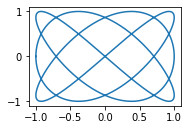

In [14]:
# Now let's try to output something cool, how about the following Lissajou figure?
a =3 
b = 4 
delta = np.pi/2
num_samples = 16*100 # Should be multiples of 16
t = np.linspace(-np.pi, np.pi, num_samples)


x = np.sin(a * t + delta)
y = np.sin(b * t)
plt.subplot(2, 2, i+1)
plt.plot(x, y)

plt.show()

In [11]:
# We will use the dynamic waveform upload

array([-1.        , -0.99993052, -0.99972208, ..., -0.99972208,
       -0.99993052, -1.        ])

In [15]:
AWG_N = num_samples
sequence = textwrap.dedent("""\
        const AWG_N = _c1_;
        wave x = zeros(AWG_N);
        wave y = zeros(AWG_N);

        while(1){
            setTrigger(1);
            setTrigger(0);
            playWave(1, x);
            playWave(2, y);
        }
        """)

# Fill in the integer constant AWG_N
sequence = sequence.replace('_c1_', str(AWG_N))



NameError: name 'textwrap' is not defined

In [ ]:

hd.set_channel_grouping(0)


# Create an instance of the AWG Module
awgModule = hd.daq.awgModule()
awgModule.set('device', hd.device_id)
awgModule.execute()

hd.compile_upload_sequence(awgModule, sequence)